# High Throughput Domain Writing Workflow




${Yongtao}$ ${Liu}$

${June}$ ${2023}$



### Install and Import

In [1]:
import os
import win32com.client
import numpy as np
import time
import h5py
import sidpy
import pyNSID
import matplotlib.pyplot as plt
from tqdm import tqdm

# import acquition.py
from Acquisition_v0_9 import Acquisition   # include the Acquistion_v.py in the same directory

### Start BEPyAE.exe and set VI

* Start BEPyAE.ext
* Set VI of BEPyAE; if this version includes PyScanner, also set VIs for PyScanner

In [3]:
newexp = Acquisition(exe_path = r"C:\Users\yla\Dropbox (ORNL)\My Files\AEcroscopy_BEPyAE\BEPyAE_Labview\BEPyAE 060523 01\BEPyAE.exe")   
# exe_path is the directory of BEPyAE; 

### Initialize Igor AR18
* Set offline development
* Build a connection between BEPyAE and AR18
* Get parameters in AR18

In [4]:
newexp.init_BEPyAE(offline_development = True) # set offline_development=True if doing offline development
                                                # executing this will also initlize AR18

> Hereinafter 
> * If no parameters are provided in a function, executing the function will utilize the default parameters within $BEPyAE.exe$.
> * Certain functions provide feedback after execution, which can be disabled by setting $feedbackon=False$. This allows you to deactivate feedback during specific iterations or instances when it is not required.
> * Note: For tip locations, -1 corresponds to the left-hand side on the x-axis and the bottom side on the y-axis, while 1 corresponds to the right-hand side on the x-axis and the top side on the y-axis.

### Set tip parameters
* set setpoint, tip locations

![image1.PNG](../../_images/image1.png)

In [5]:
newexp.tip_control(tip_parms_dict = {"set_point_V_00": 1, "next_x_pos_00": -0.5, "next_y_pos_01": 0.5},
                   do_move_tip = True, 
                   do_set_setpoint = True) # Executing this code will set setpoint to 1 V, 
                                           # and move tip to location [0.5, 0.5]

Setpoint is:  1.0
Tip parameters are:  (-0.5, 0.5, 0.2)


### Set IO 
This defines IO parameters, such as AFM platform: AR18, amplifiers, channel data types, etc

In [6]:
newexp.define_io_cluster(IO_cluster_parms_dict = {"analog_output_amplifier_06": 1, 
                                                  "channel_01_type_07": 1, 
                                                  "channel_02_type_08": 2,"channel_03_type_09": 3,})

('0 Cypher AR18',
 '6124',
 4000000.0,
 10.0,
 10.0,
 'AC and DC on AO0',
 10.0,
 'topography',
 'current',
 'aux',
 'external')

### Set BE pulse parameters 

In [7]:
# set BE parameters
newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 335, "band_width_Hz_01": 100,
                                       "amplitude_V_02": 1, "phase_variation_03": 1,
                                       "repeats_04": 4, "req_pulse_duration_s_05": 4,
                                       "auto_smooth_ring_06": 1}, 
                      do_create_be_waveform = True)

BE parameters are:  (335000.0, 100000.0, 1.0, 1.0, 4, 0.004, 1, 3352.2952763920002, 0.12159459061880915)


### Run a BE Line scan to test parameters
* This is a single BE line scan
* This returns 5 datasets: quick_fitting, complex spectra, and 3 channels

In [8]:
# Do a single line scan
qk_fit, com_spec, chn1, chn2, chn3 = newexp.do_line_scan(line_scan_parms_dict = {"num_BE_pulses_01": 32,
                                                                                 "start_x_pos_00": -0.5, "start_y_pos_01": 0,
                                                                                 "stop_x_pos_02": 0.5, "stop_y_pos_03": 0},
                                                         upload_to_daq = True, do_line_scan = True)

voltage offset and number of BE pulse are:  (0.0, 32)
line scan start and end positions:  (-0.5, 0.0, 0.5, 0.0)


> *Tests Done*

## Experiment Starts

>In this experiment, we begin by applying a DC pulse to switch the ferroelectric polarization. Subsequently, a BEPFM (Bias-Enhanced Piezoresponse Force Microscopy) measurement is conducted to image the domain structure.

1. To initiate the measurement process, we first need to determine the location for each individual measurement. There are two scenarios to consider:

> * For each measurement, a new location is chosen, requiring a location array to record all the measurements as demonstrated below.

![image2.PNG]("image2.png") 

> * Alternatively, all measurements are conducted at the same location. In this case, the measurement location needs to be initialized each time a new measurement is started, as shown below.

![image3.PNG](../_images/image3.png)

2. Prior to experiments, we also need to establish the DC pulse parameters including pulse magnitude $A$ and pulse length $t$ , as shown below. Again, there are two scenarios to consider here:

![image4.PNG](src="../_images/image4.png")

> * The pulse parameters can be pre-defined, e.g., the parameter values can be uniformly distributed within a specified range or customized to suit the experimental requirements.
> * The pulse parameters can be random values within a defined space, typically these random values is a uniform distribution across that space in principle.

## Experiment 1. Perform each measurement at a new location with pre-defined pulse parameters

### Prior to expeirment, set a directory to save data

In [10]:
os.chdir(r"C:\Users\yla\Dropbox (ORNL)\My Files\AEcroscopy_BEPyAE")

### Step 1. Generate a location array

In [11]:
# All locations span across [start_point_x, end_point_x] in x-direction and [start_point_y, end_point_y] in y-direction.
# There are num_x rows and num_y columns in the locations array

start_point_x = -0.9   # Define location array parameters
end_point_x = 0.9
start_point_y = -0.9
end_point_y = 0.9
num_x = 2
num_y = 2

# Generate location array
pos_x = np.linspace(-0.9, 0.9, num_x)
pos_y = np.linspace(-0.9, 0.9, num_y)
pulse_pos = np.meshgrid(pos_x, pos_y)
pulse_pos_x = pulse_pos[0].reshape(-1)
pulse_pos_y = pulse_pos[1].reshape(-1)  # pulse_pos_x and pulse_pos_y are the coordinates of all locations

# Set BEPFM image size
img_size = 0.1

# Check
if img_size > np.abs(pos_x[0]-pos_x[1]):
    print ("Alert: there will be image overlap along x-direction")
elif img_size > np.abs(pos_y[0]-pos_y[1]):
    print ("Alert: there will be image overlap along y-direction")
else:
    print("{} locations are ready for experiments".format(len(pulse_pos_x)))

4 locations are ready for experiments


### Step 2. Establish pulse parameters 

In [12]:
# uniformly distributed pulse parameters
min_voltage = 5
max_voltage = 9
Vdc_amp = np.linspace(min_voltage, max_voltage, num_x)  # pulse magnitude

min_time_log = -4
max_time_log = 1
Vdc_time = np.linspace(min_time_log, max_time_log, num_y, dtype = np.float32())
Vdc_time = np.power(10, Vdc_time)                 # pulse time

# Establish pulse parameters
Vdc = np.meshgrid(Vdc_amp, Vdc_time)
Vdc_amp = Vdc[0].reshape(-1)
Vdc_time = Vdc[1].reshape(-1)

if len(Vdc_amp) > len(pulse_pos_x):
    print ("Error: No enough locations to test all pulse conditions")
else:
    print ("{} pulse parameters are ready for expierments".format(len(Vdc_amp)))
    
# save pulse condition
np.save("Vdc_list.npy", np.asarray([Vdc_amp, Vdc_time]))

4 pulse parameters are ready for expierments


### Step 3. Start experiment


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Setpoint is:  1.0
Tip parameters are:  (-0.9, -0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


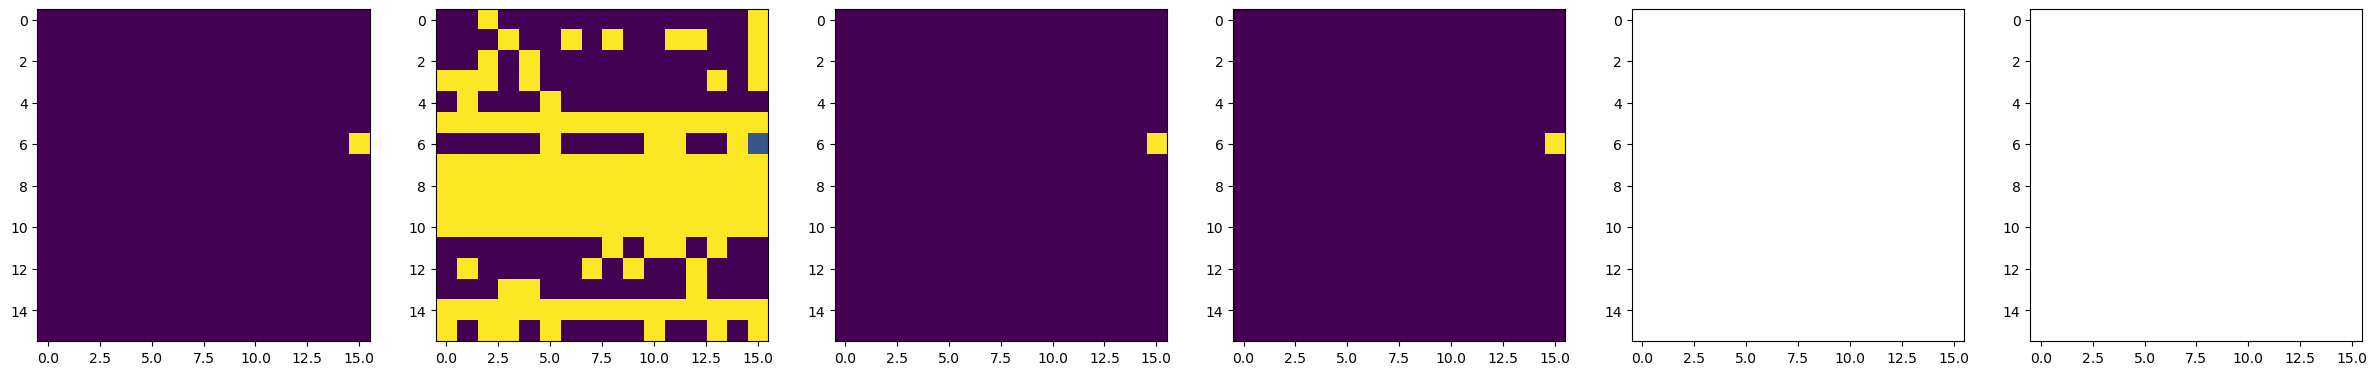


 25%|█████████████████████                                                               | 1/4 [00:28<01:25, 28.36s/it]

Setpoint is:  1.0
Tip parameters are:  (0.9, -0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


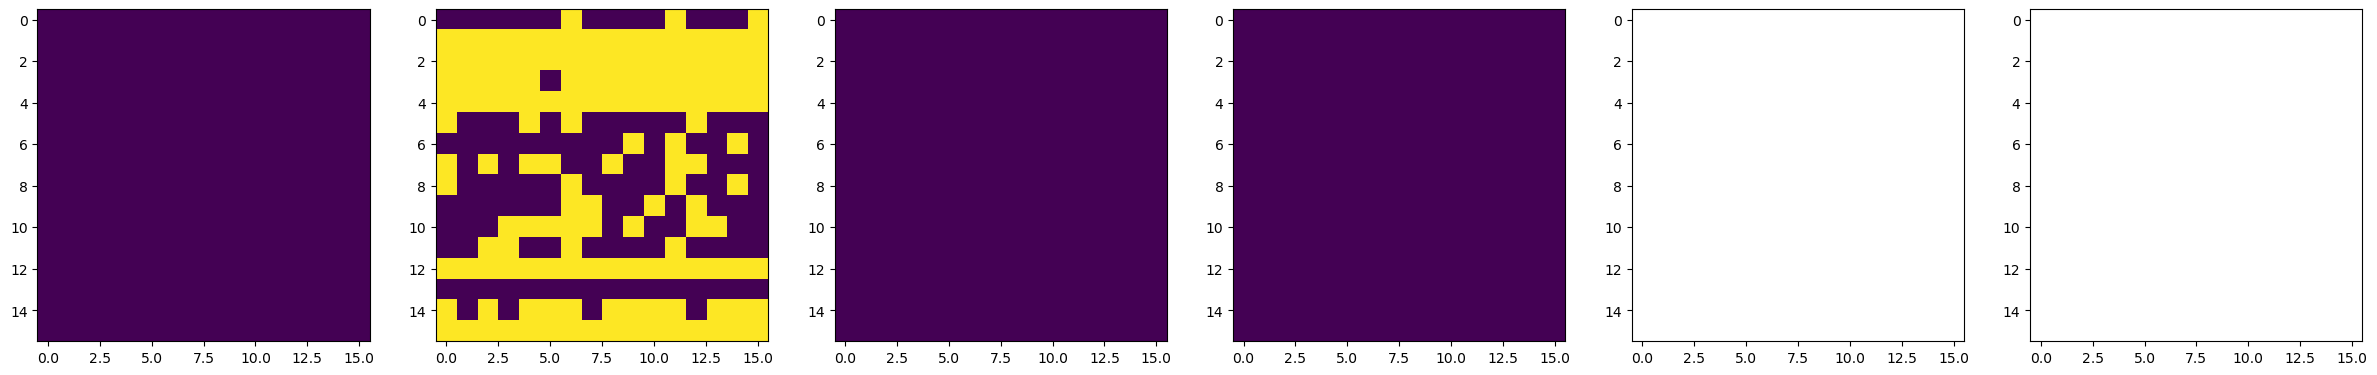


 50%|██████████████████████████████████████████                                          | 2/4 [00:56<00:56, 28.33s/it]

Setpoint is:  1.0
Tip parameters are:  (-0.9, 0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


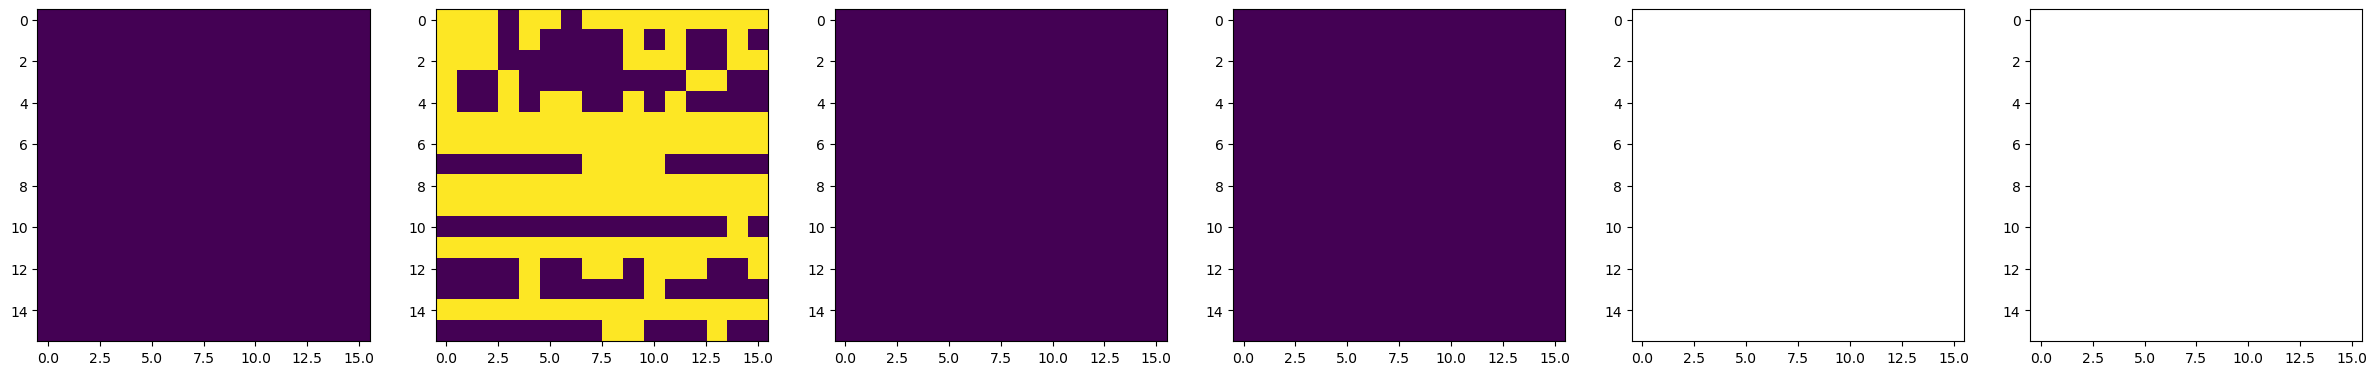


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:55<00:42, 42.22s/it]

Setpoint is:  1.0
Tip parameters are:  (0.9, 0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


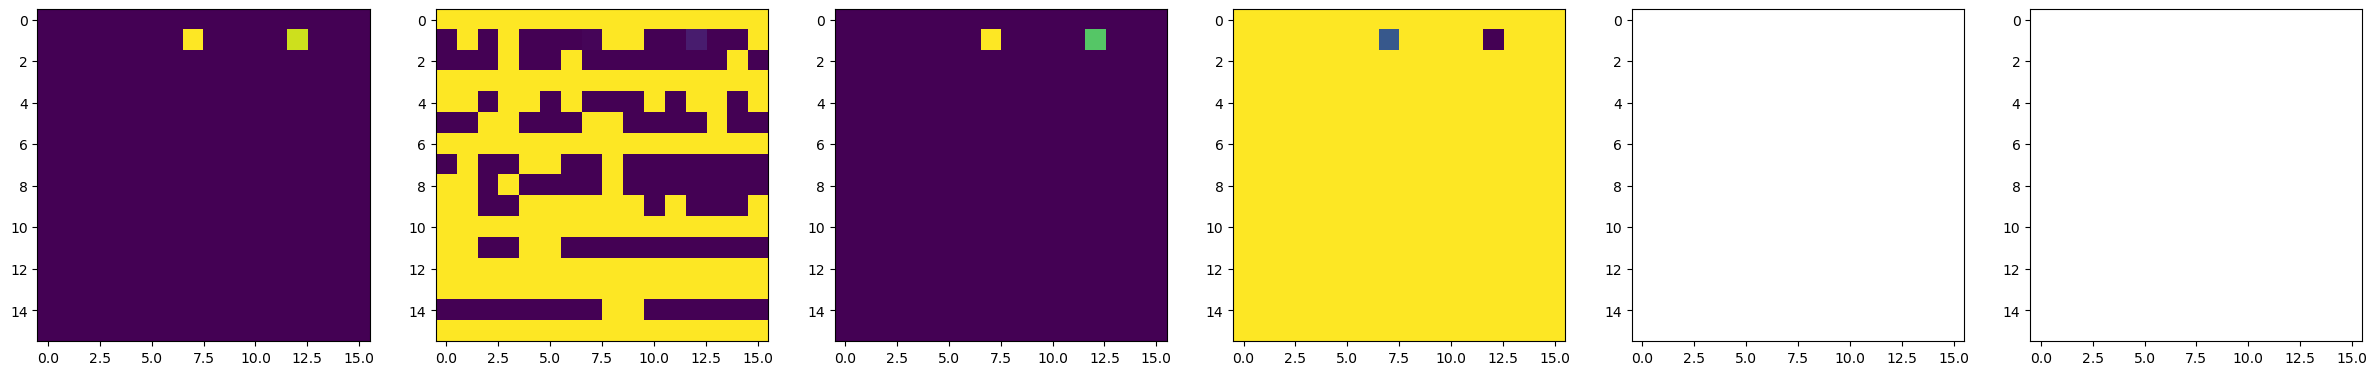

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:53<00:00, 43.50s/it]


In [14]:
for i in tqdm(range(len(Vdc_amp))):
    #####################----------- Move tip to the pulse location -----------##################### 
    newexp.tip_control(tip_parms_dict = {"set_point_V_00": 1,
                                         "next_x_pos_00": pulse_pos_x[i],
                                         "next_y_pos_01": pulse_pos_y[i]},
                       do_move_tip = True, do_set_setpoint = True)
    time.sleep(0.2)
    
    #####################----------- Apply pulse -----------##################### 
    V_amp = Vdc_amp[i]
    V_time = Vdc_time[i]
    newexp.define_apply_pulse(pulse_parms_dict = {"pulse_init_amplitude_V_00": 0, "pulse_mid_amplitude_V_01": V_amp,
                                                  "pulse_final_amplitude_V_02": 0, "pulse_on_duration_s_03": V_time,
                                                  "rise_time_s_05": 1E-4, "pulse_final_duration_s_04": 20E-3,
                                                  "pulse_repeats_06": 1},
                              do_create_pulse = True, do_upload_pulse = True, do_apply_pulse = False)
    # 
    time.sleep(1)
    newexp.define_apply_pulse(pulse_parms_dict = {"pulse_init_amplitude_V_00": 0, "pulse_mid_amplitude_V_01": V_amp,
                                                  "pulse_final_amplitude_V_02": 0, "pulse_on_duration_s_03": V_time,
                                                  "rise_time_s_05": 1E-4, "pulse_final_duration_s_04": 20E-3,
                                                  "pulse_repeats_06": 1},
                              do_create_pulse = True, do_upload_pulse = True, do_apply_pulse = True)
    
    time.sleep(2)
    
    #####################----------- Do BEPFM to image domain -----------#####################
    dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 16,
                                                                           "scan_x_start": pulse_pos_x[i]-(img_size/2), 
                                                                           "scan_y_start": pulse_pos_y[i]-(img_size/2),
                                                                           "scan_x_stop": pulse_pos_x[i]+(img_size/2), 
                                                                           "scan_y_stop": pulse_pos_y[i]+(img_size/2)},
                                                      file_name = "Domain_Writing_{}".format(i), 
                                                      progress_on = False, ploton = False)
    time.sleep(0.5)
    
    # Plot BEPFM images
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
    ax1.imshow(dset_pfm[:,:,0])
    ax2.imshow(dset_pfm[:,:,1])
    ax3.imshow(dset_pfm[:,:,2])
    ax4.imshow(dset_pfm[:,:,3])
    ax5.imshow(dset_chns[0,:,:])
    ax6.imshow(dset_chns[1,:,:])
    plt.show()

### Step 4. Do a BEPFM at the whole experiment area

 [progress: 0:00:35] |************************************  | (ETA:   0:00:01) C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


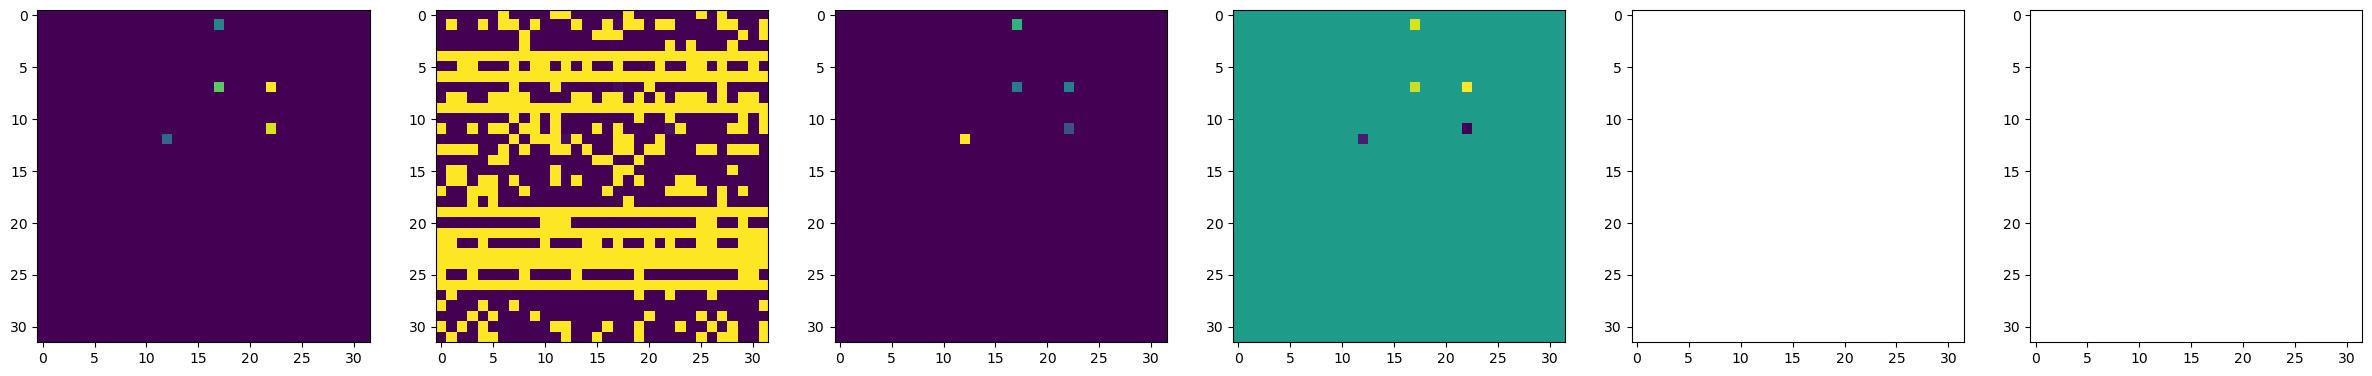

In [15]:
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 32, "scan_x_start": -1.0,
                                                                       "scan_y_start": -1.0,"scan_x_stop": 1.0,
                                                                       "scan_y_stop": 1.0}, 
                                                  file_name = "pfm_whole", ploton = False)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
ax1.imshow(dset_pfm[:,:,0])
ax2.imshow(dset_pfm[:,:,1])
ax3.imshow(dset_pfm[:,:,2])
ax4.imshow(dset_pfm[:,:,3])
ax5.imshow(dset_chns[0,:,:])
ax6.imshow(dset_chns[1,:,:])
plt.show()

## Experiment 2. Perform measurement with random pulse parameters

### Prior to expeirment, set a directory to save data

In [16]:
os.chdir(r"C:\Users\yla\Dropbox (ORNL)\My Files\AEcroscopy_BEPyAE")

### Step 1. Generate a location array

In [17]:
# All locations span across [start_point_x, end_point_x] in x-direction and [start_point_y, end_point_y] in y-direction.
# There are num_x rows and num_y columns in the locations array

start_point_x = -0.9   # Define location array parameters
end_point_x = 0.9
start_point_y = -0.9
end_point_y = 0.9
num_x = 2
num_y = 2

# Generate location array
pos_x = np.linspace(-0.9, 0.9, num_x)
pos_y = np.linspace(-0.9, 0.9, num_y)
pulse_pos = np.meshgrid(pos_x, pos_y)
pulse_pos_x = pulse_pos[0].reshape(-1)
pulse_pos_y = pulse_pos[1].reshape(-1)  # pulse_pos_x and pulse_pos_y are the coordinates of all locations

# Set BEPFM image size
img_size = 0.1

# Check
if img_size > np.abs(pos_x[0]-pos_x[1]):
    print ("Alert: there will be image overlap along x-direction")
elif img_size > np.abs(pos_y[0]-pos_y[1]):
    print ("Alert: there will be image overlap along y-direction")
else:
    print("{} locations are ready for experiments".format(len(pulse_pos_x)))

4 locations are ready for experiments


### Step 2. Establish pulse space

In [18]:
# pulse magnitude space
min_voltage = 5
max_voltage = 9

# pulse time space
min_time_log = -4
max_time_log = 1

### Step 3. Start experiment


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Setpoint is:  1.0
Tip parameters are:  (-0.9, -0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


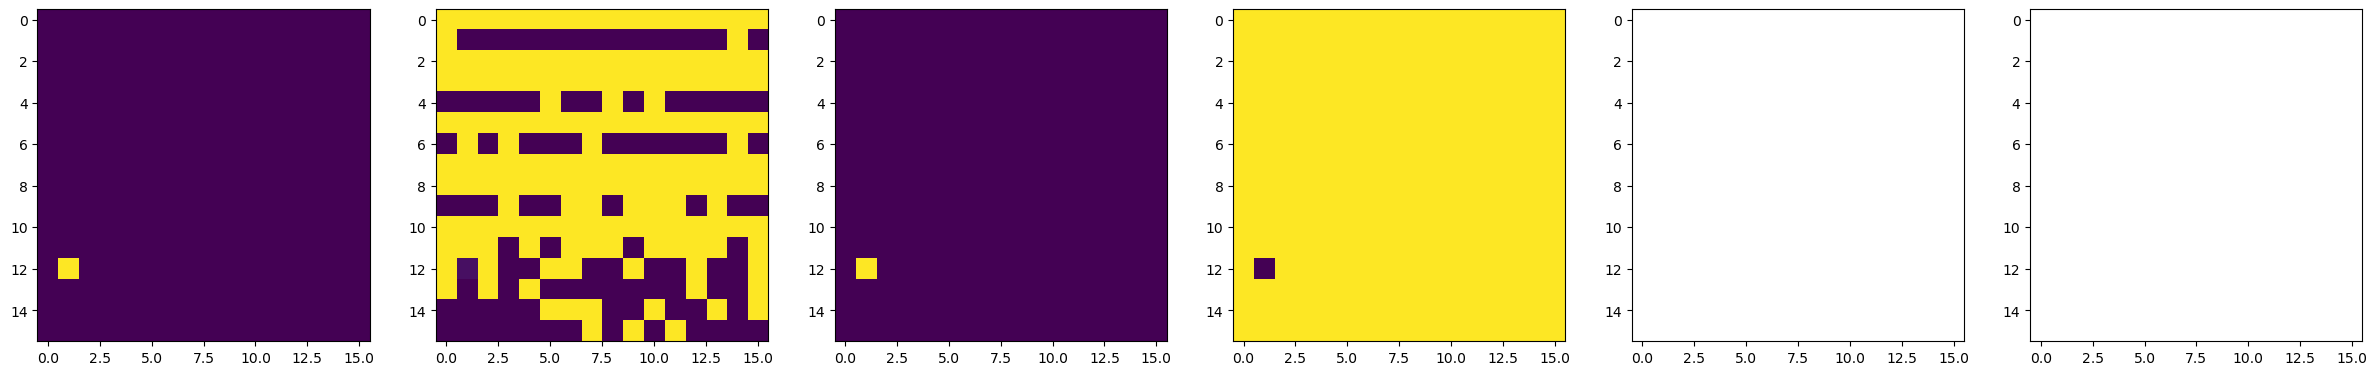


  1%|▊                                                                               | 1/100 [00:39<1:04:42, 39.22s/it]

Setpoint is:  1.0
Tip parameters are:  (0.9, -0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


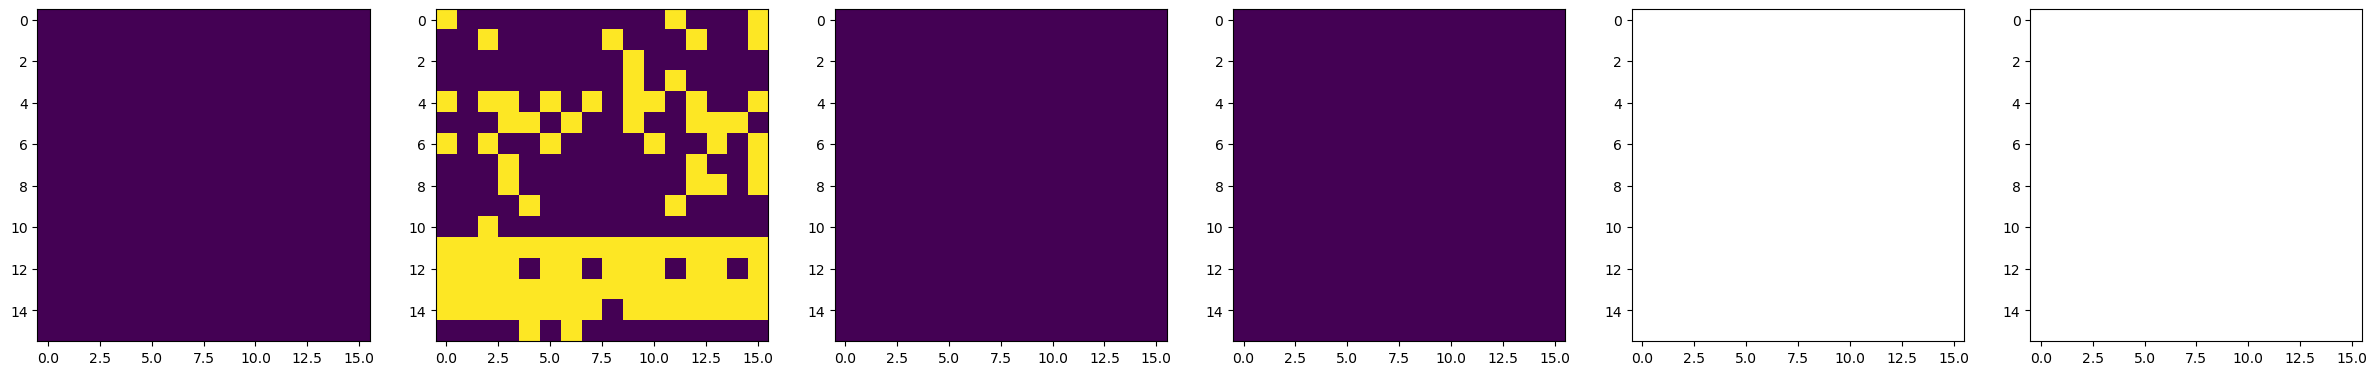


  2%|█▌                                                                              | 2/100 [01:16<1:02:08, 38.05s/it]

Setpoint is:  1.0
Tip parameters are:  (-0.9, 0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


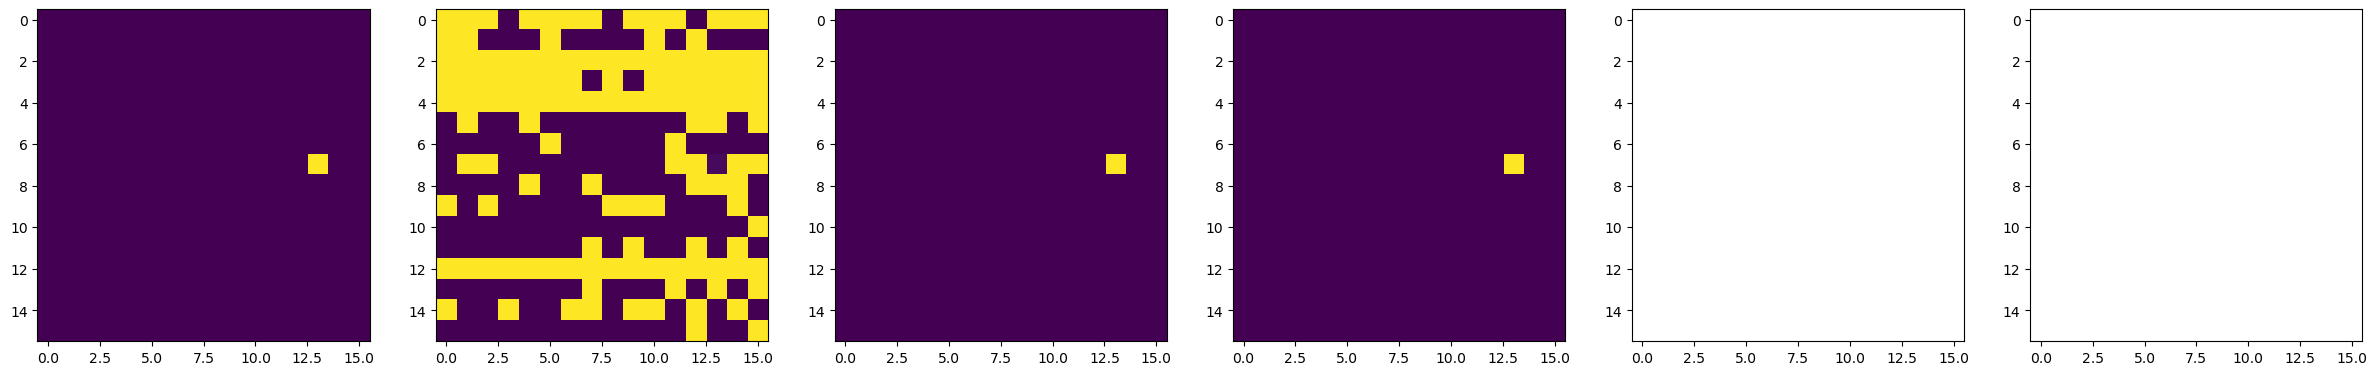


  3%|██▍                                                                               | 3/100 [01:45<54:46, 33.88s/it]

Setpoint is:  1.0
Tip parameters are:  (0.9, 0.9, 0.5)


C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\yla\AppData\Local\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


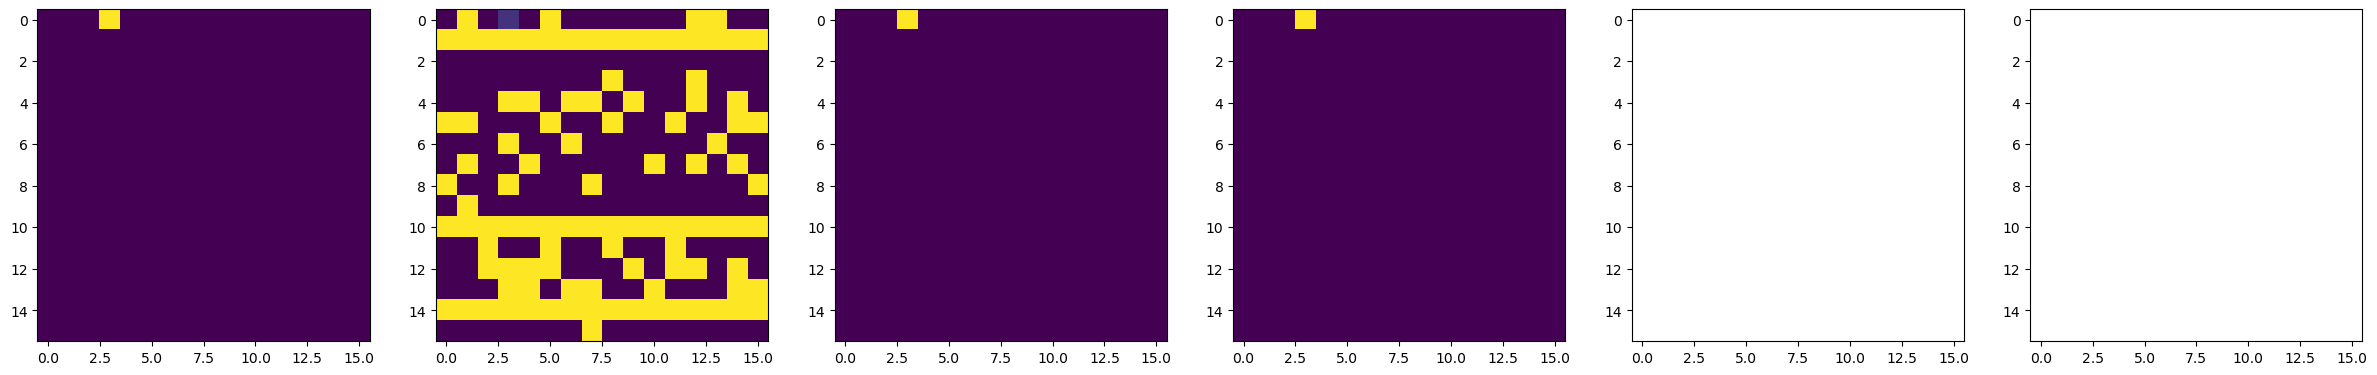

  4%|███▎                                                                              | 4/100 [02:19<55:50, 34.90s/it]


IndexError: index 4 is out of bounds for axis 0 with size 4

In [19]:
# Set measurement iteration number
iterations = 100
# Set lists to save pulse parameters
Vdc_amp = []
Vdc_time = []

# Measurement starts
for i in tqdm(range(iterations)):
    #####################----------- Move tip to the pulse location -----------##################### 
    newexp.tip_control(tip_parms_dict = {"set_point_V_00": 1,
                                         "next_x_pos_00": pulse_pos_x[i],
                                         "next_y_pos_01": pulse_pos_y[i]},
                       do_move_tip = True, do_set_setpoint = True)
    time.sleep(0.2)
    
    #####################----------- Apply pulse -----------##################### 
    # Random pulse parameters
    V_amp = np.random.uniform(min_voltage, max_voltage)
    V_time = np.random.uniform(min_time_log, max_time_log)
    V_time = np.power(10, V_time)
    # Add parameters to Vdc lists
    Vdc_amp.append(V_amp)
    Vdc_time.append(V_time)
    
    # Apply pulse
    newexp.define_apply_pulse(pulse_parms_dict = {"pulse_init_amplitude_V_00": 0, "pulse_mid_amplitude_V_01": V_amp,
                                                  "pulse_final_amplitude_V_02": 0, "pulse_on_duration_s_03": V_time,
                                                  "rise_time_s_05": 1E-4, "pulse_final_duration_s_04": 20E-3,
                                                  "pulse_repeats_06": 1},
                              do_create_pulse = True, do_upload_pulse = True, do_apply_pulse = False)
    # 
    time.sleep(1)
    newexp.define_apply_pulse(pulse_parms_dict = {"pulse_init_amplitude_V_00": 0, "pulse_mid_amplitude_V_01": V_amp,
                                                  "pulse_final_amplitude_V_02": 0, "pulse_on_duration_s_03": V_time,
                                                  "rise_time_s_05": 1E-4, "pulse_final_duration_s_04": 20E-3,
                                                  "pulse_repeats_06": 1},
                              do_create_pulse = True, do_upload_pulse = True, do_apply_pulse = True)
    
    time.sleep(2)
    
    #####################----------- Do BEPFM to image domain -----------#####################
    dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 16,
                                                                           "scan_x_start": pulse_pos_x[i]-(img_size/2), 
                                                                           "scan_y_start": pulse_pos_y[i]-(img_size/2),
                                                                           "scan_x_stop": pulse_pos_x[i]+(img_size/2), 
                                                                           "scan_y_stop": pulse_pos_y[i]+(img_size/2)},
                                                      file_name = "Domain_Writing_{}".format(i), 
                                                      progress_on = False, ploton = False)
    time.sleep(0.5)
    
    # Plot BEPFM images
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
    ax1.imshow(dset_pfm[:,:,0])
    ax2.imshow(dset_pfm[:,:,1])
    ax3.imshow(dset_pfm[:,:,2])
    ax4.imshow(dset_pfm[:,:,3])
    ax5.imshow(dset_chns[0,:,:])
    ax6.imshow(dset_chns[1,:,:])
    plt.show()

# Save pulse parameters
np.save("Vdc_list.npy", np.asarray([Vdc_amp, Vdc_time]))

### Step 4. Do a BEPFM at the whole experiment area

In [ ]:
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 32, "scan_x_start": -1.0,
                                                                       "scan_y_start": -1.0,"scan_x_stop": 1.0,
                                                                       "scan_y_stop": 1.0}, 
                                                  file_name = "pfm_whole", ploton = False)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
ax1.imshow(dset_pfm[:,:,0])
ax2.imshow(dset_pfm[:,:,1])
ax3.imshow(dset_pfm[:,:,2])
ax4.imshow(dset_pfm[:,:,3])
ax5.imshow(dset_chns[0,:,:])
ax6.imshow(dset_chns[1,:,:])
plt.show()